# REINFORCE
_____________

## 0. Background

REINFORCE is a policy-based reinforcement learning algorithm where we treat reinforcement learning a bit more like a supervised learning problem: that is, we *directly differentiate the reinforcement learning objective*, which is to maximise return.  

When using a policy gradient approach during an RL problem, the agent passes a state through its policy network in a forward pass, which returns a probability distribution over the action space. The agent then selects an action by sampling from the action space according to this probability distribution, which triggers the next state. For each subsequent time-step, this 'state-forward propagation-action selection' pattern is repeated and the sequence of states and actions taken is termed a **trajectory**. At the end of the episode, the agent collects a reward value. If it won, this indicates that its recent trajectory was a good one and therefore the policy network's parameters should be updated such that in future, that particular trajectory is more likely to be experienced.  

Our goal is to find the set of (weight and bias) parameters for our policy neural network that  maximises return. The difference in the REINFORCE method is that we do this by directly trying to maximise the return function:  

<img src="reinforce_return.png" width=400px>  

How? Let's compare with a Supervised Learning approach to gain a sense.  

### Relationship to Supervised Learning
In SL, given a batch of inputs, our network generates an output (say a binary classification of 0 or 1) of the same size. During training, we compare this output to the label by using a cost function, such as cross-entropy or MSE for example. Our goal in SL is for the network to learn to produce outputs that are as close as possible to the labelled data. In other words, we aim to **minimize the cost function**. The latter is a function of our network's weights and biases and minimising it involves gradually changing these parameters such that we travel on the surface of this function seeking a global minimum.  

We achieve this by using **gradient descent**. First, by differentiating the equation for our particular choice of cost function, we can find the slope of any point (specified by our model's parameters) on that function. This tells us *what will happen to the cost if we move parameters in a certain direction* in the vicinity of the current parameter values. This is called the **gradient**. If we know the gradient, then to update parameters in our quest for a global minimum, all we need to do is multiply that gradient by a learning rate and subtract this from our current parameters. Let's unpack this a little.  

If the **gradient is positive**, that means the cost function is increasing and therefore moving in the opposite direction of the gradient (remember the subtraction sign) is the right thing to do. If the **gradient is negative**, we want to move in the same direction as the gradient, which is what happens because we're subtracting a negative value (same as adding) from our current parameters. The learning rate value simply controls how large a step we take in updating our weight and bias parameters. As we iterate through our training set, we compute the cost function as an indicator of training progress. This can also be useful in debugging bias vs variance problems with our model.  

### Applying to Reinforcement Learning
In RL with policy gradients, instead of a cost function we have an expected return function U which we're trying to maximise rather than minimise, but our approach is fundamentally the same. Return U is a function of the policy network's parameters therefore we travel the surface of U by varying weights and biases in the network, aiming to reach a global 'peak.  

Once again we use **gradient descent**; if we differentiate U, expected return, we obtain:
<img src="reinforce_diffreturn.png" width=400px>  

The purple term gives us the gradient of the probability of selecting each action 'at' from each state 'st' in a trajectory, with regard to the parameters theta. If we multiply that by the trajectory return, we arrive at a nice property. **If return was positive** for a set of parameters, the gradient of U wrt those parameters will be positive therefore when updating parameters we move **in the direction of the gradient** because we are adding the gradient scaled by learning rate to our current parameters. If **return was negative**, we want to move in the **opposite direction to the gradient** so we add the negative of the gradient scaled by learning rate to our current parameters, same as subtracting from them.  

In other words, when we talk about the gradient of at|st wrt theta, what we mean is we're finding out **how we need to shift theta if we want to increase or decrease the probability of a trajectory**. Moving in the **direction of that gradient** in our parameter update means **increasing the probability of generating that trajectory again** with our network. This is what happens if we obtain a positive return and multiply the gradient of at|st wrt theta by it, which keeps the sign. If we obtain a negative return, we want to **lower the probability of our network generating that trajectory** again - so we move in the direction **opposite to the gradient**. If return is negative, this is exactly what happens, since multiplying by return means we flip the sign on our gradient.

## 1. Import packages

In [1]:
import gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

## 2. Instantiate the environment and device
Cartpole has a continuous 4-dimensional observation space and a 2-dimensional discrete action space: we either take a step left or right, to balance the pole.

In [2]:
env = gym.make('CartPole-v0')
#env.seed(0)
print('observation space:', env.observation_space)
print('action space:', env.action_space)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Training on {}.'.format(device))

observation space: Box(4,)
action space: Discrete(2)
Training on cpu.


## 3. Instantiate Policy network and methods
We define a policy network with input size matching the state space and output size matching the action space dimensions. In between we have a hidden layer, with a number of units of our choosing.  

We define a forward propagation graph where the hidden layer uses ReLu activation and the output layer uses softmax, since we want it to output action probabilities summing to 1 over the full action space.  

Lastly, we define an action selection method. This turns an input state into a tensor and forward propagates that input through the current policy network in order to obtain a probability distribution over actions. It then generates a categorical distribution over this vector of probabilities,
```Python
    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probabilities = self.forward(state).cpu()
        m = Categorical(probabilities) ```
Then retrieves a category (or index) from this distribution by sampling from it according to ```probabilities```. It returns this action index as well as the log of its probability, which we will need for calculating expected return gradient.

In [3]:
class Policy(nn.Module):
    def __init__(self, input_size=4, hidden_size=16, output_size=2):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.softmax(x, dim=1)
        return x
    
    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probabilities = self.forward(state).cpu()
        m = Categorical(probabilities) # Creates a categorical distribution over a vector of probabilities
        action = m.sample() # Retrieve a category from the distribution by sampling according to 'probabilities'
        return action.item(), m.log_prob(action) # Return the category (action index) and the log of its probability

## 4. Training function
As for previous problems, we initiate a deque and a list for keeping track of 100 most recent and episode by episode scores. Then we run an episode and a nested time-step loop.  

Notice for each time-step within an episode we save the log probabilities of each action taken in the episode, as we need this for calculating the gradient:
```Python
    for i_episode in range(1, n_episodes+1):
        saved_log_probs = []
        ...
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)```
At the end of the episode, we tally up its return,
```Python
            R = sum([a*b for a,b in zip(discounts, rewards)])```
Which we multiply by the log probability and add up for every time step,
```Python
                policy_loss = []
                for log_prob in saved_log_probs:
                    policy_loss.append(-log_prob * R)
                policy_loss = torch.cat(policy_loss).sum()```
Finishing by computing the differentiation with .backward() and updating weights with .step():
```Python
                    policy_loss.backward()
                    optimizer.step()```

In [6]:
def reinforce(n_episodes=1000, max_t=1000, gamma=1.0, print_every=100):
    scores_deque = deque(maxlen=100)
    scores = []
    
    for i_episode in range(1, n_episodes+1):
        saved_log_probs = []
        rewards = []
        state = env.reset()
        
        # state-action-reward-state loop
        for t in range(max_t):
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            if done:
                break
                
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))
        
        discounts = [gamma**i for i in range(len(rewards)+1)]
        R = sum([a*b for a,b in zip(discounts, rewards)])
        
        policy_loss = []
        for log_prob in saved_log_probs:
            policy_loss.append(-log_prob * R)
        policy_loss = torch.cat(policy_loss).sum()
        
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()
        
        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque)>=195.0:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            break
        
    return scores

In [13]:
s = env.observation_space.shape[0]
h = 16
a = env.action_space.n

policy = Policy(s, h, a).to(device)
optimizer = optim.Adam(policy.parameters(), lr=1e-2)

scores = reinforce(n_episodes=2000)

Episode 100	Average Score: 34.91
Episode 200	Average Score: 40.99
Episode 300	Average Score: 63.71
Episode 400	Average Score: 42.19
Episode 500	Average Score: 65.68
Episode 600	Average Score: 56.35
Episode 700	Average Score: 79.31
Episode 800	Average Score: 92.48
Episode 900	Average Score: 143.62
Environment solved in 891 episodes!	Average Score: 195.54


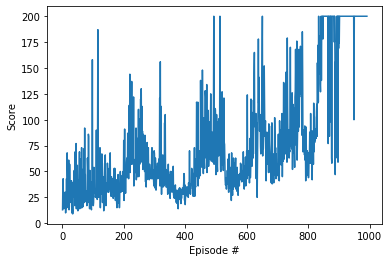

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

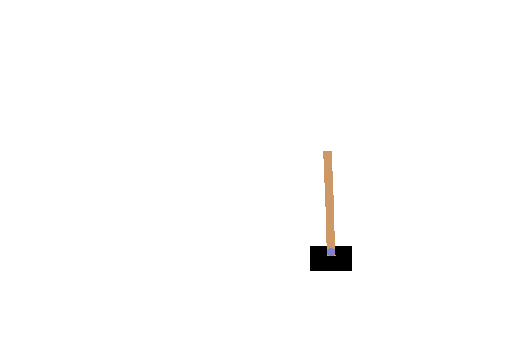

In [15]:
from IPython import display

state = env.reset()
plt.figure(figsize=(9,9))
img = plt.imshow(env.render(mode='rgb_array')) # only call this once
plt.axis('off')
for _ in range(1000):
    img.set_data(env.render(mode='rgb_array')) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)
    action, _ = policy.act(state)
    state, reward, done, _ = env.step(action)
    if done:
        break
env.close()